In [12]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import xgboost as xgb
import graphviz

sns.set_theme(style="whitegrid", rc={"grid.linestyle": "--", "grid.color": "grey", "grid.linewidth": 0.4})

# #a09fa1
# #f205a2
# #038525

In [13]:
def error(y_true, y_pred, verbose=False):
    if verbose:
        print(f"MAPE: {mean_absolute_percentage_error(y_true, y_pred)}, MAE: {mean_absolute_error(y_true, y_pred)}, RMSE: {np.sqrt(mean_squared_error(y_true, y_pred))}")
    else:
        return [mean_absolute_percentage_error(y_true, y_pred), mean_absolute_error(y_true, y_pred), np.sqrt(mean_squared_error(y_true, y_pred))]
    

def min_max_scaling(column):
    min_val = column.min()
    max_val = column.max()
    scaled_column = (column - min_val) / (max_val - min_val)
    return scaled_column

# WCZYTANIE DANYCH

Dane muszą być .csv i zawierać kolumnę "Date". Jeśli jest więcej kolumn to należy sprecyzować col_data.

In [14]:
def read_data(file_path, resample):

    missing_values = ["n/a", "na", "--", "none", "None", "NaN"]
    df = pd.read_csv(file_path, parse_dates=["Date"], index_col="Date", na_values = missing_values).squeeze()
    df.index = pd.DatetimeIndex(df.index)

    if resample != None:
        df = df.resample(resample).mean()

    print(f"Liczba danych: {len(df)}")
    print(f"Liczba brakujących wartości: {df.isnull().sum()}")
    df = df.interpolate()
    print(f"Liczba brakujących wartości po interpolacji: {df.isnull().sum()} \nWszystkie wartości są skończone: {np.isfinite(df).sum() == len(df)}")

    return df

In [15]:
def split_data(df, ratio, verbose=False):
    train = df[:round(ratio*len(df))]
    test = df[round(ratio*len(df)) :]

    if verbose:
        print(f"Długość zbioru treningowego: {len(train)}, \nDługość zbioru testowego: {len(test)}, \nProcent jaki stanowi zbiór testowy: {(1-ratio)*100}%")

        plt.plot(train, color = "black", label="Zbiór treningowy")
        plt.plot(test, color = "red", label="Zbiór testowy")
        plt.ylabel('Wartość')
        plt.xlabel('Data')
        plt.xticks(rotation=45)
        plt.legend()
        plt.savefig("images\\data\\_split.pdf", bbox_inches='tight')
        plt.show()
        

    return train, test

## Features

In [20]:
def create_features(df, features_type):

    if features_type in ["wave", "mix"]:
        df_features = pd.DataFrame({"Value": df})
        df_features["Seconds"] = df.index.map(pd.Timestamp.timestamp)

        hour = 60*60
        day = 24*hour
        week = 7*day
        year = 365.2425*day

        #df_features['Day sin'] = np.sin(df_features['Seconds'] * (2* np.pi / day))
        #df_features['Day cos'] = np.cos(df_features['Seconds'] * (2 * np.pi / day))
        #df_features['Week sin'] = np.sin(df_features['Seconds'] * (2* np.pi / week))
        #df_features['Week cos'] = np.cos(df_features['Seconds'] * (2 * np.pi / week))
        df_features['Year sin'] = np.sin(df_features['Seconds'] * (2 * np.pi / year))
        df_features['Year cos'] = np.cos(df_features['Seconds'] * (2 * np.pi / year))
        df_features = df_features.drop("Seconds", axis=1)
        df_features = df_features.drop("Value", axis=1)

    if features_type == "calendar":
        df_features = pd.DataFrame({
                        "month": df.index.month,
                        "year": df.index.year,
                        #"dayOfWeek": df.index.dayofweek + 1,
                        #"dayOfMonth": df.index.day,
                        "dayOfYear": df.index.dayofyear
                        },
                        index=df.index)

    if features_type == "mix":
        df_features_mix = pd.DataFrame({
                            "month": df.index.month,
                            "year": df.index.year,
                            #"dayOfWeek": df.index.dayofweek + 1,
                            #"dayOfMonth": df.index.day,
                            "dayOfYear": df.index.dayofyear
                            },
                            index=df.index)
        
        df_features = pd.concat([df_features, df_features_mix], axis=1, ignore_index=False)
    
    return df_features

# XGB

In [21]:
def xgb_fit(file_name, resample, ratio, features_type):
    # , n_estimators=2000, early_stopping_rounds=10

    # read & split data
    df = read_data(file_path=f"{file_name}.csv", resample=resample)
    train, test = split_data(df, ratio=ratio, verbose=False)

    # create features
    exog_train = create_features(train, features_type=features_type)
    exog_test = create_features(test, features_type=features_type)

    # define model
    model_xgb = xgb.XGBRegressor()

    # fit & predict
    model_xgb.fit(X=exog_train, 
                y=train, 
                eval_set=[(exog_train, train), (exog_test, test)],
                verbose=100)
    df_forecast_xgb = model_xgb.predict(exog_test)

    # save
    df_predictions_xgb = pd.DataFrame(data = df_forecast_xgb,
                                      index=test.index,
                                      columns=[["Predictions"]])
    
    error(y_true = test.values, y_pred = df_predictions_xgb.values, verbose=True)
    
    # get and save features importances
    df_feature_importances_xgb = pd.DataFrame(data = model_xgb.feature_importances_,
                                              index = model_xgb.feature_names_in_,
                                              columns = ["importance"]).sort_values("importance")

    df_feature_importances_xgb.plot(kind="barh")
    plt.show()
    
    
    plt.plot(test.index, test.values, label="Dane testowe", color="black")
    plt.plot(df_predictions_xgb.index, df_predictions_xgb.values, label="XGB", color="red")
    plt.xticks(rotation = 45)
    plt.xlabel("Data")
    plt.ylabel("Temperatura")
    plt.legend()
    

    plt.plot(train.index, train.values, label="Dane treningowe", color="#606060")
    handles, labels = plt.gca().get_legend_handles_labels() 
    order = [2, 0, 1]
    plt.legend([handles[i] for i in order], [labels[i] for i in order])
    
    plt.show()

    #xgb.plot_tree(model_xgb)
    #plt.savefig('tree_plot.pdf')
    #plt.show()
    return error(y_true = test.values, y_pred = df_predictions_xgb.values, verbose=False)


Liczba danych: 3652
Liczba brakujących wartości: 2
Liczba brakujących wartości po interpolacji: 0 
Wszystkie wartości są skończone: True
[0]	validation_0-rmse:8.20149	validation_1-rmse:8.52755


[99]	validation_0-rmse:2.01554	validation_1-rmse:2.73590
MAPE: 0.2631216084042687, MAE: 2.1710804167185747, RMSE: 2.735895084947226


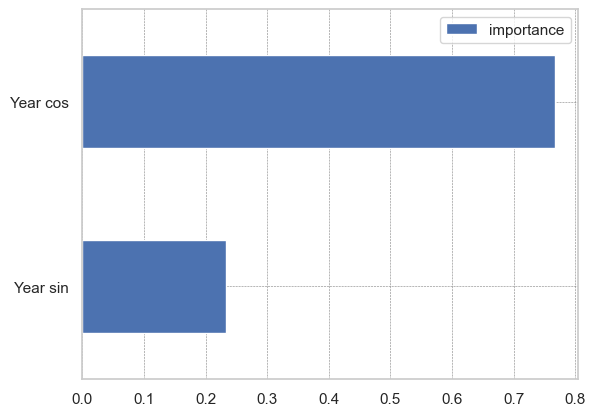

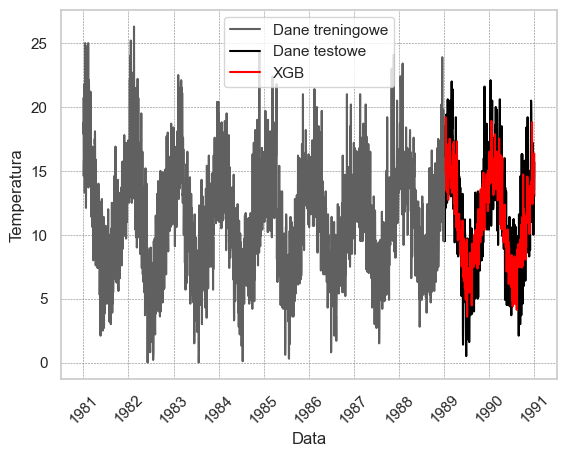

Liczba danych: 3652
Liczba brakujących wartości: 2
Liczba brakujących wartości po interpolacji: 0 
Wszystkie wartości są skończone: True
[0]	validation_0-rmse:8.20164	validation_1-rmse:8.53686
[99]	validation_0-rmse:1.52836	validation_1-rmse:3.18606
MAPE: 0.3143008608388786, MAE: 2.475246825283521, RMSE: 3.1860643456318933


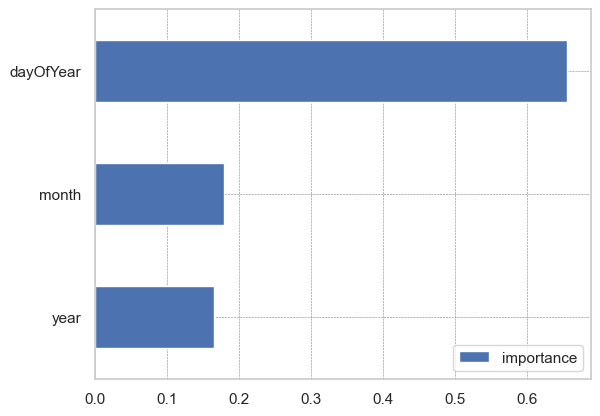

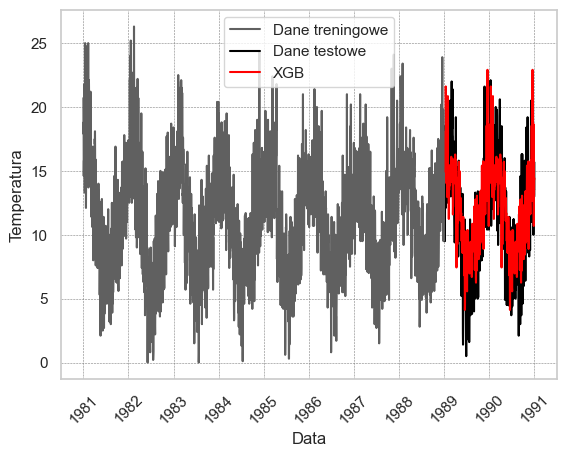

Liczba danych: 3652
Liczba brakujących wartości: 2
Liczba brakujących wartości po interpolacji: 0 
Wszystkie wartości są skończone: True
[0]	validation_0-rmse:8.19637	validation_1-rmse:8.54726
[99]	validation_0-rmse:1.52741	validation_1-rmse:2.96150
MAPE: 0.30635284350475944, MAE: 2.319146427389694, RMSE: 2.9614992204958037


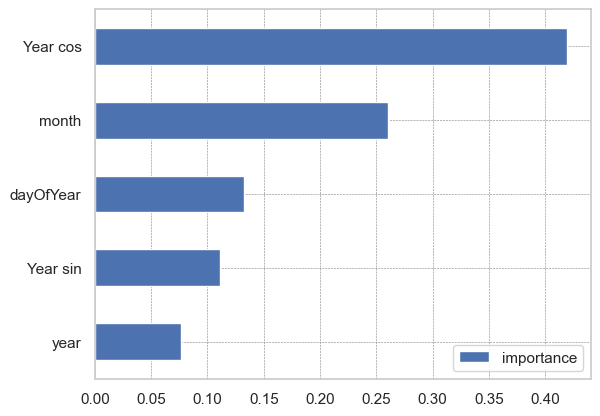

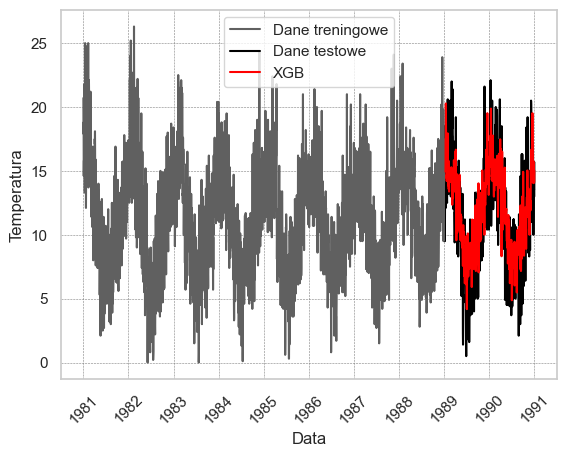

[0.30635284350475944, 2.319146427389694, 2.9614992204958037]

In [22]:
xgb_fit("temperatures", resample="D", ratio=0.8, features_type="wave")
xgb_fit("temperatures", resample="D", ratio=0.8, features_type="calendar")
xgb_fit("temperatures", resample="D", ratio=0.8, features_type="mix")

Liczba danych: 508
Liczba brakujących wartości: 0
Liczba brakujących wartości po interpolacji: 0 
Wszystkie wartości są skończone: True
[0]	validation_0-rmse:8.57895	validation_1-rmse:8.86280


[99]	validation_0-rmse:2.39107	validation_1-rmse:9.40023
MAPE: 0.09171223620477036, MAE: 7.413782280369811, RMSE: 9.400230944362832


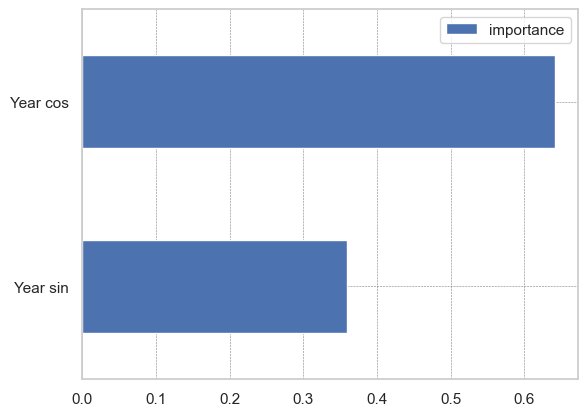

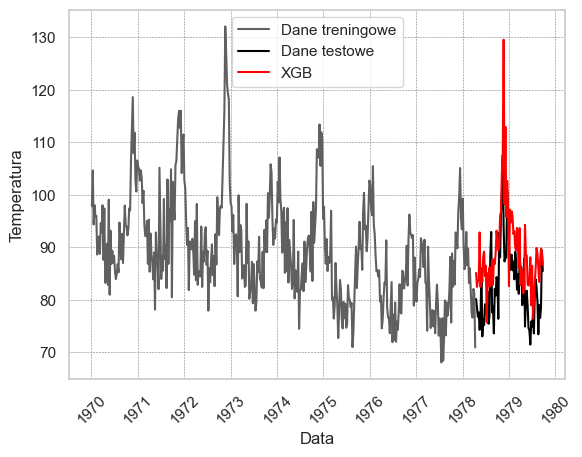

Liczba danych: 508
Liczba brakujących wartości: 0
Liczba brakujących wartości po interpolacji: 0 
Wszystkie wartości są skończone: True
[0]	validation_0-rmse:7.85283	validation_1-rmse:7.51178
[99]	validation_0-rmse:0.88327	validation_1-rmse:8.53023
MAPE: 0.08212965946949684, MAE: 6.942058647557309, RMSE: 8.530232584319503


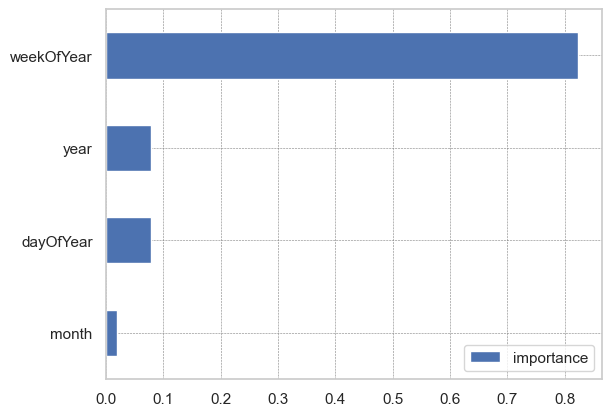

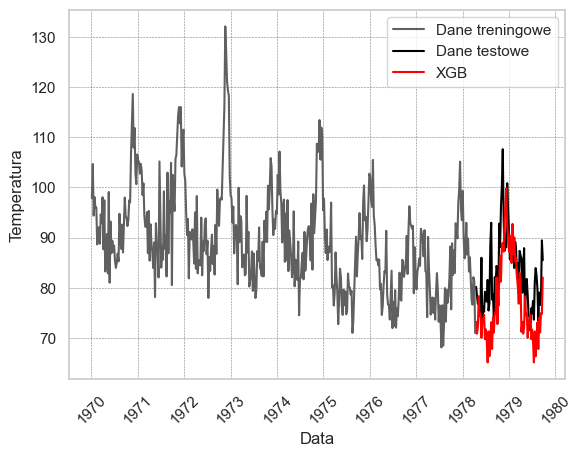

Liczba danych: 508
Liczba brakujących wartości: 0
Liczba brakujących wartości po interpolacji: 0 
Wszystkie wartości są skończone: True
[0]	validation_0-rmse:7.81995	validation_1-rmse:7.57341
[99]	validation_0-rmse:0.66081	validation_1-rmse:6.63453
MAPE: 0.061116143385119434, MAE: 5.215201243350381, RMSE: 6.634533427944116


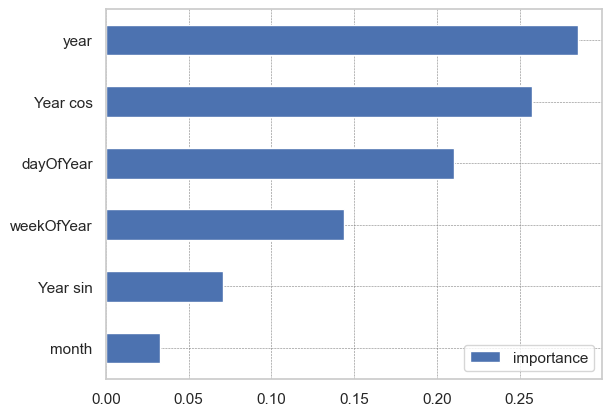

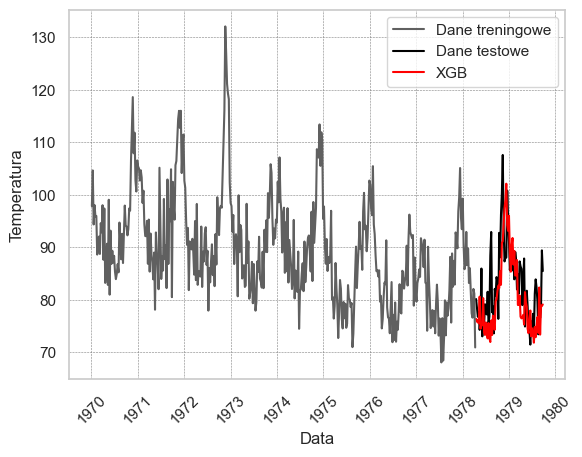

[0.061116143385119434, 5.215201243350381, 6.634533427944116]

In [10]:
xgb_fit("mort", resample="W", ratio=0.85, features_type="wave")
xgb_fit("mort", resample="W", ratio=0.85, features_type="calendar")
xgb_fit("mort", resample="W", ratio=0.85, features_type="mix")

Liczba danych: 144
Liczba brakujących wartości: 0
Liczba brakujących wartości po interpolacji: 0 
Wszystkie wartości są skończone: True
[0]	validation_0-rmse:87.70024	validation_1-rmse:220.62117
[99]	validation_0-rmse:11.27491	validation_1-rmse:194.63252
MAPE: 0.401518276912447, MAE: 185.2278130271218, RMSE: 194.6325195297902


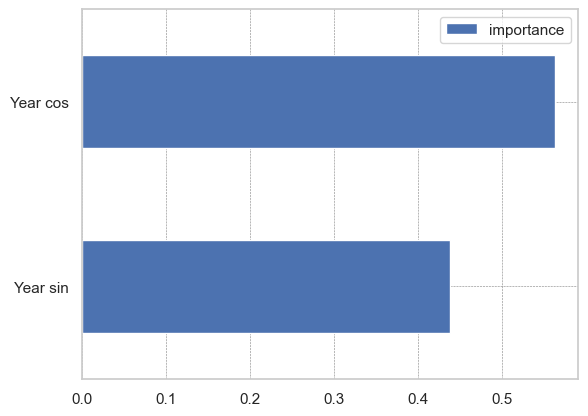

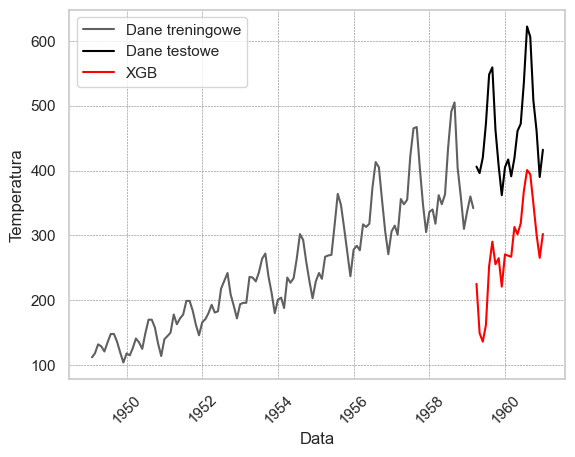

Liczba danych: 144
Liczba brakujących wartości: 0
Liczba brakujących wartości po interpolacji: 0 
Wszystkie wartości są skończone: True
[0]	validation_0-rmse:69.94325	validation_1-rmse:193.15642
[99]	validation_0-rmse:0.04424	validation_1-rmse:88.03325
MAPE: 0.17575186113929936, MAE: 81.13246016068892, RMSE: 88.03325082730501


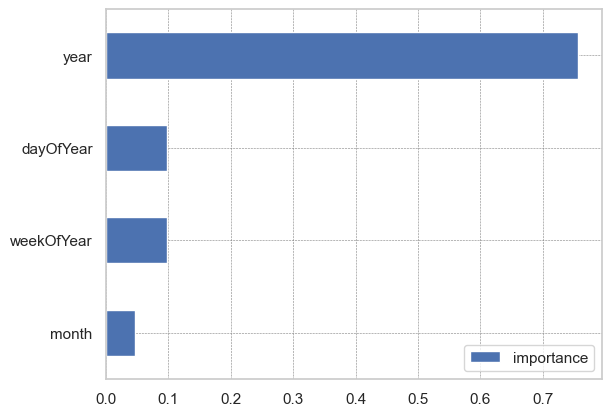

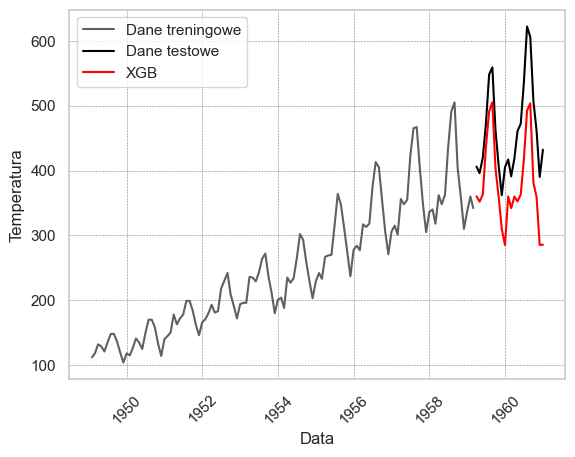

Liczba danych: 144
Liczba brakujących wartości: 0
Liczba brakujących wartości po interpolacji: 0 
Wszystkie wartości są skończone: True
[0]	validation_0-rmse:69.96444	validation_1-rmse:191.52874
[99]	validation_0-rmse:0.02187	validation_1-rmse:87.85982
MAPE: 0.1763786218484465, MAE: 82.70623779296875, RMSE: 87.85982266904904


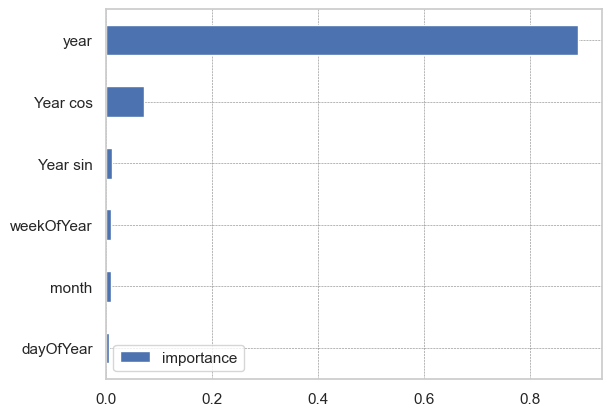

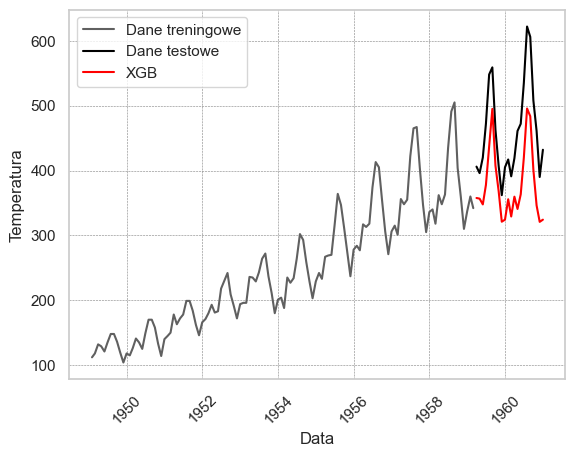

[0.1763786218484465, 82.70623779296875, 87.85982266904904]

In [9]:
xgb_fit("airline", resample="M", ratio=0.85, features_type="wave")
xgb_fit("airline", resample="M", ratio=0.85, features_type="calendar")
xgb_fit("airline", resample="M", ratio=0.85, features_type="mix")